In [1]:
import os
old_cwd = os.getcwd()
os.chdir('..')
new_cwd = os.getcwd()
print('Working directory is changed from {} to {}.'.format(old_cwd, new_cwd))

Working directory is changed from /home/sungjae/Projects/KerasMNIST/results to /home/sungjae/Projects/KerasMNIST.


- Purpose
  1. Import digit images and make them as a dataset.
  2. Run prediction on the dataset.

# Import digit images

In [2]:
import os, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from predict import img2np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

data_dir = os.path.join(old_cwd, '01-03-03')
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

dir_img_path = os.path.join('..', 'DynamicMNIST-Data', 'data_raster_digit_1000')
img_ext = '.png'
batch_size = 256 * 4
model_path = 'cnn.h5'

In [3]:
def get_class_from(filename):
    digit = int(filename.split('_')[-6])
    return digit

In [4]:
img_paths = [os.path.join(dir_img_path, f) for f in os.listdir(dir_img_path) if os.path.splitext(f)[-1] == img_ext]

In [5]:
img_names = [f for f in os.listdir(dir_img_path) if os.path.splitext(f)[-1] == img_ext]

In [6]:
np_img = img2np(os.path.join(dir_img_path, img_names[0]))
print(np_img.shape)

(1, 28, 28, 1)


In [7]:
model = load_model(model_path)

2022-04-01 15:07:41.692289: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 15:07:42.386128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9643 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:5e:00.0, compute capability: 7.5


# Prediction for the MNIST test dataset

In [8]:
title = 'result-mnist'

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#x_test = np.invert(x_test)
x_test = x_test.astype('float32')
x_test = x_test / 255
dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

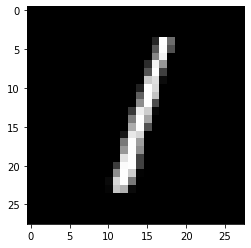

In [10]:
plt.imshow(x_test[2], cmap='gray')

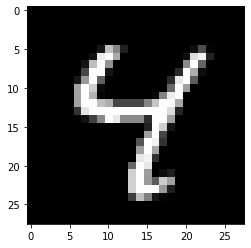

In [11]:
plt.imshow(x_test[6], cmap='gray')

In [12]:
y_pred_all = list()
for x, y in dataset.batch(batch_size):
    y_out = model.predict(x)
    y_pred = np.argmax(y_out, axis=-1)
    y_pred_all += y_pred.tolist()

2022-04-01 15:07:43.994889: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


In [13]:
y_trgt = y_test
y_pred = y_pred_all

Accuracy  : 0.99
Precision : [0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99]
Recall    : [0.99 1.   0.99 0.99 0.99 0.99 0.99 0.99 0.98 0.98]
F1-socre  : [0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99]
Mean
Precision : 0.99
Recall    : 0.99
F1-socre  : 0.99


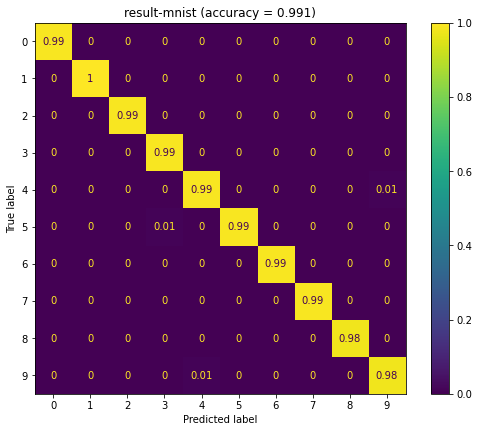

In [14]:
accuracy = accuracy_score(y_trgt, y_pred)
precision, recall, f1score, _ = precision_recall_fscore_support(y_trgt, y_pred, beta=1)

cm = confusion_matrix(y_trgt, y_pred, normalize='true')
cm = np.round(cm,2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
font = {'size' : 10}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize=(8, 6))
plt.tight_layout(pad=2)
plt.title('{} (accuracy = {})'.format(title, round(accuracy,3)))
disp.plot(ax=ax)

plt.savefig(os.path.join(data_dir, '{}.svg'.format(title)))

print('Accuracy  :', np.round(accuracy, 2))
print('Precision :', np.round(precision, 2))
print('Recall    :', np.round(recall, 2))
print('F1-socre  :', np.round(f1score, 2))

print('Mean')
print('Precision :', np.round(precision.mean(), 2))
print('Recall    :', np.round(recall.mean(), 2))
print('F1-socre  :', np.round(f1score.mean(), 2))

## Analyze the results

Wrong predictions for digit 0 :     9 / 1000
Wrong predictions for digit 1 :     1 / 1000
Wrong predictions for digit 2 :     8 / 1000
Wrong predictions for digit 3 :     7 / 1000
Wrong predictions for digit 4 :     7 / 1000
Wrong predictions for digit 5 :     8 / 1000
Wrong predictions for digit 6 :    10 / 1000
Wrong predictions for digit 7 :    10 / 1000
Wrong predictions for digit 8 :    15 / 1000
Wrong predictions for digit 9 :    18 / 1000
index 717
y_trgt 0
y_pred 5


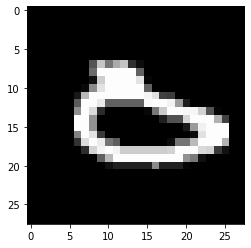

index 1527
y_trgt 1
y_pred 5


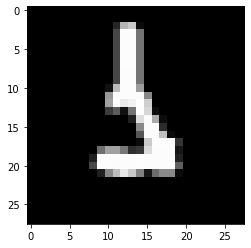

index 321
y_trgt 2
y_pred 7


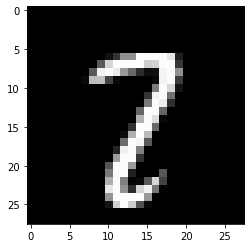

index 449
y_trgt 3
y_pred 5


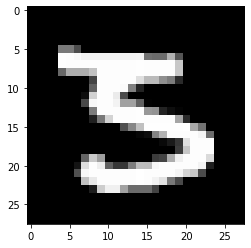

index 740
y_trgt 4
y_pred 9


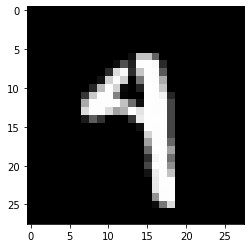

index 340
y_trgt 5
y_pred 3


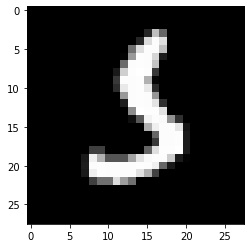

index 445
y_trgt 6
y_pred 0


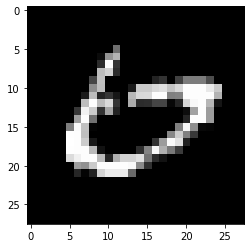

index 1039
y_trgt 7
y_pred 2


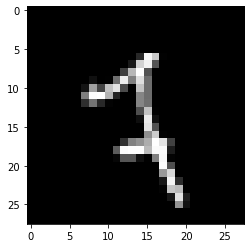

index 582
y_trgt 8
y_pred 2


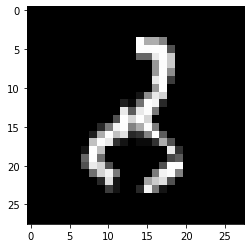

index 882
y_trgt 9
y_pred 7


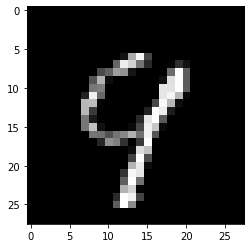

In [15]:
y_trgt = np.array(y_trgt)
y_pred = np.array(y_pred)

for digit in range(10):
    indexes_digit = np.squeeze(np.argwhere((y_trgt != y_pred) & (y_trgt == digit)), axis=-1)
    print('Wrong predictions for digit {} : {:5d} / {}'.format(digit, len(indexes_digit), len(y_trgt)//10))

print('====================')

for digit in range(10):
    indexes_digit = np.squeeze(np.argwhere((y_trgt != y_pred) & (y_trgt == digit)), axis=-1)
    if len(indexes_digit) == 0:
        continue    
    i = indexes_digit[0]
    print('index', i)
    print('y_trgt', y_trgt[i])
    print('y_pred', y_pred[i])
    plt.imshow(x_test[i], cmap='gray')
    plt.show()

# Prediction for our data: DMNIST preprocessed like MNIST

In [16]:
pad_width = 0
rm_pad = False
title = 'result-dmnist-mnist-preprcessing'

In [17]:
inputs = list()
targets = list()
for img_name in img_names:
    img_path = os.path.join(dir_img_path, img_name)
    np_img = img2np(img_path, pad_width=pad_width, rm_pad=rm_pad)
    label = get_class_from(img_name)
    inputs.append(np_img.squeeze(axis=0))
    targets.append(label)
print(len(inputs))
print(len(targets))
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
print(len(dataset))
#dataset = dataset.shuffle(len(dataset), reshuffle_each_iteration=True)
#dataset.batch(batch_size)

10000
10000
10000


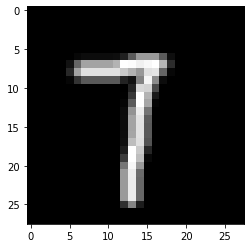

In [18]:
plt.imshow(inputs[0], cmap='gray')

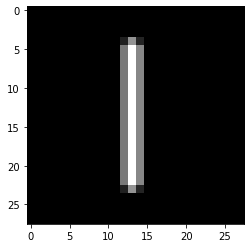

In [19]:
plt.imshow(inputs[18], cmap='gray')

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))

In [21]:
y_pred_all = list()
for x, y in dataset.batch(batch_size):
    y_out = model.predict(x)
    y_pred = np.argmax(y_out, axis=-1)
    y_pred_all += y_pred.tolist()

In [22]:
y_trgt = targets
y_pred = y_pred_all

Accuracy  : 1.0
Precision : [1.   1.   1.   1.   1.   1.   1.   1.   1.   0.99]
Recall    : [1.   1.   1.   1.   0.99 1.   1.   1.   1.   1.  ]
F1-socre  : [1.   1.   1.   1.   0.99 1.   1.   1.   1.   0.99]
Mean
Precision : 1.0
Recall    : 1.0
F1-socre  : 1.0


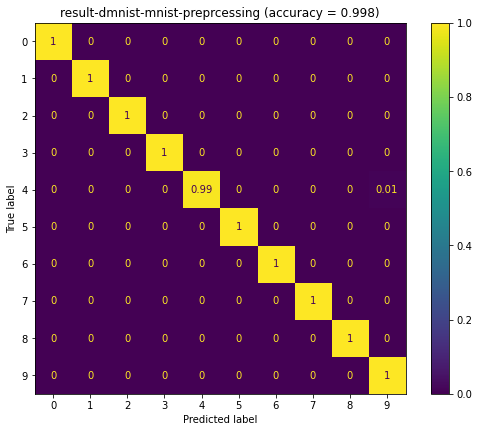

In [23]:
accuracy = accuracy_score(y_trgt, y_pred)
precision, recall, f1score, _ = precision_recall_fscore_support(y_trgt, y_pred, beta=1)

cm = confusion_matrix(y_trgt, y_pred, normalize='true')
cm = np.round(cm,2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
font = {'size' : 10}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize=(8, 6))
plt.tight_layout(pad=2)
plt.title('{} (accuracy = {})'.format(title, round(accuracy,3)))
disp.plot(ax=ax)

plt.savefig(os.path.join(data_dir, '{}.svg'.format(title)))

print('Accuracy  :', np.round(accuracy, 2))
print('Precision :', np.round(precision, 2))
print('Recall    :', np.round(recall, 2))
print('F1-socre  :', np.round(f1score, 2))

print('Mean')
print('Precision :', np.round(precision.mean(), 2))
print('Recall    :', np.round(recall.mean(), 2))
print('F1-socre  :', np.round(f1score.mean(), 2))

## Analyze the results

Wrong predictions for digit 0 :     0 / 1000
Wrong predictions for digit 1 :     0 / 1000
Wrong predictions for digit 2 :     2 / 1000
Wrong predictions for digit 3 :     0 / 1000
Wrong predictions for digit 4 :    11 / 1000
Wrong predictions for digit 5 :     0 / 1000
Wrong predictions for digit 6 :     0 / 1000
Wrong predictions for digit 7 :     3 / 1000
Wrong predictions for digit 8 :     1 / 1000
Wrong predictions for digit 9 :     1 / 1000
index 3171
y_trgt 2
y_pred 1


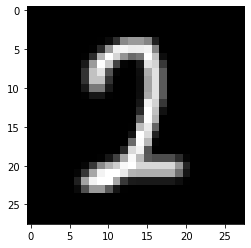

index 6661
y_trgt 2
y_pred 1


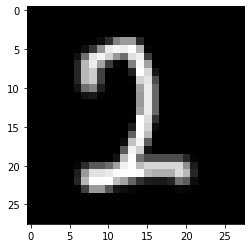

index 1108
y_trgt 4
y_pred 9


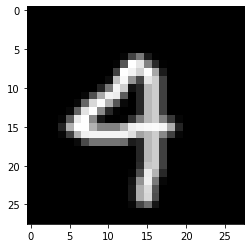

index 2267
y_trgt 4
y_pred 9


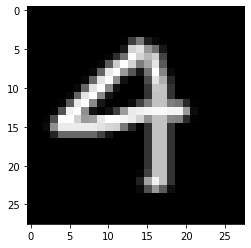

index 2647
y_trgt 4
y_pred 9


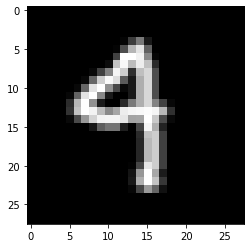

index 2651
y_trgt 4
y_pred 9


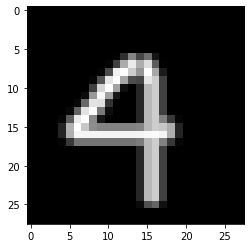

index 2828
y_trgt 4
y_pred 9


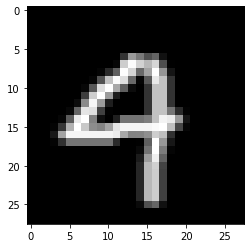

index 3266
y_trgt 4
y_pred 9


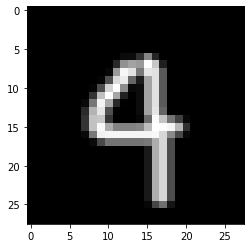

index 4036
y_trgt 4
y_pred 9


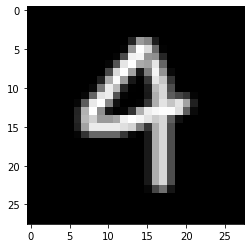

index 5203
y_trgt 4
y_pred 9


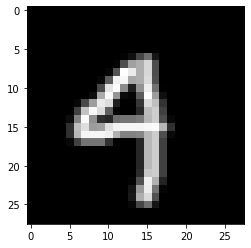

index 6017
y_trgt 4
y_pred 9


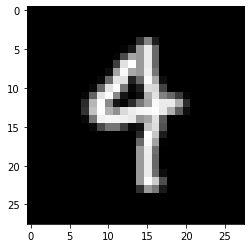

index 8791
y_trgt 4
y_pred 9


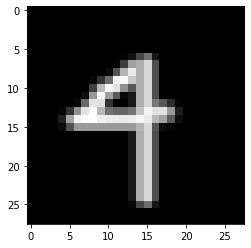

index 9872
y_trgt 4
y_pred 9


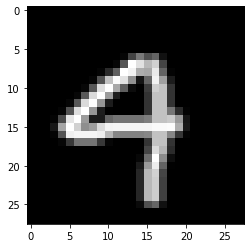

index 4374
y_trgt 7
y_pred 9


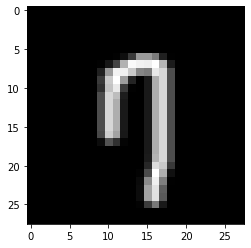

index 4540
y_trgt 7
y_pred 9


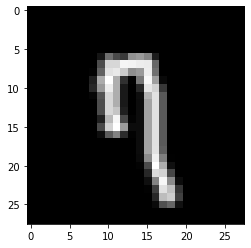

index 9993
y_trgt 7
y_pred 9


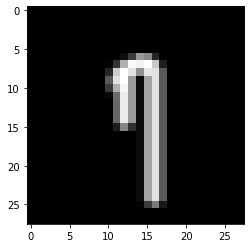

index 3781
y_trgt 8
y_pred 6


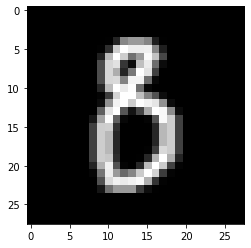

index 6096
y_trgt 9
y_pred 7


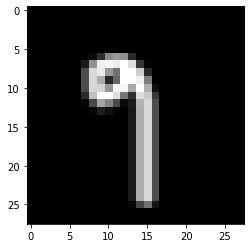

The indexes of wrong prediction
[3171, 6661, 1108, 2267, 2647, 2651, 2828, 3266, 4036, 5203, 6017, 8791, 9872, 4374, 4540, 9993, 3781, 6096]


In [24]:
y_trgt = np.array(y_trgt)
y_pred = np.array(y_pred)

for digit in range(10):
    indexes_digit = np.squeeze(np.argwhere((y_trgt != y_pred) & (y_trgt == digit)), axis=-1)
    print('Wrong predictions for digit {} : {:5d} / {}'.format(digit, len(indexes_digit), len(y_trgt)//10))

print('====================')

wrong_indexes = list()

for digit in range(10):
    indexes_digit = np.squeeze(np.argwhere((y_trgt != y_pred) & (y_trgt == digit)), axis=-1)
    if len(indexes_digit) == 0:
        continue
    for i in indexes_digit:
        wrong_indexes.append(i)
        print('index', i)
        print('y_trgt', y_trgt[i])
        print('y_pred', y_pred[i])
        plt.imshow(inputs[i], cmap='gray')
        plt.show()
print('The indexes of wrong prediction')
print(wrong_indexes)